In [1]:
import sys, os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import argparse
import wandb
import logging

root_dir = r'../..'
SEED = 42
TOL_FP = 1e-12

plt.rc('font', size=18)#weight='bold', 
plt.rc('legend', fontsize=18)
plt.rc('lines', linewidth=3, markersize=9)
mpl.rcParams['axes.grid'] = True

markers = ['o','^','s','p','d']
colors = ['b','g','r','c','m','y']

# Bounds

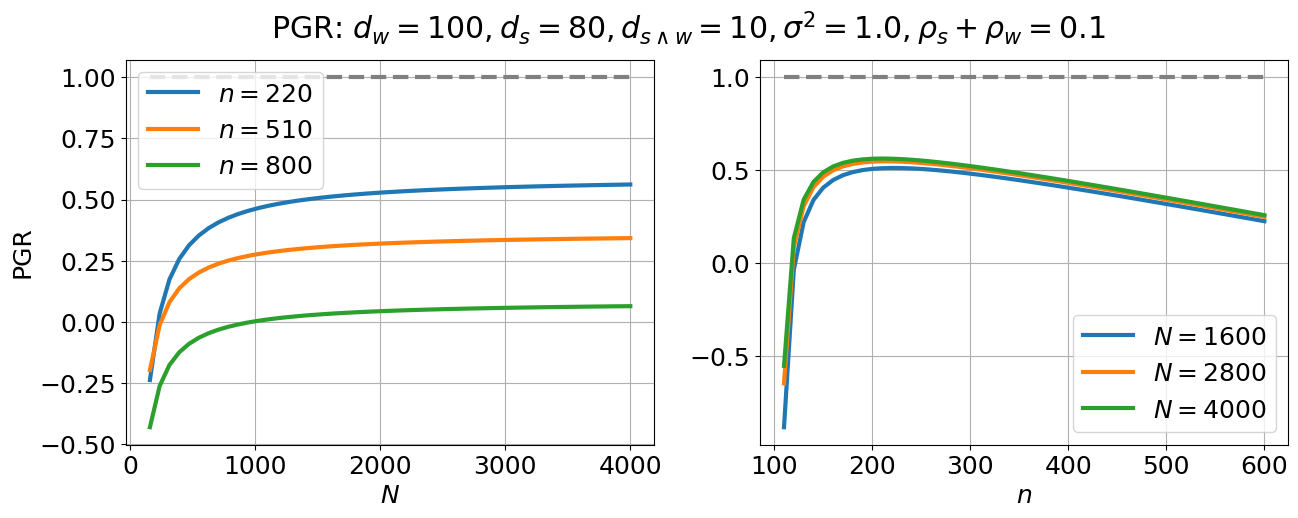

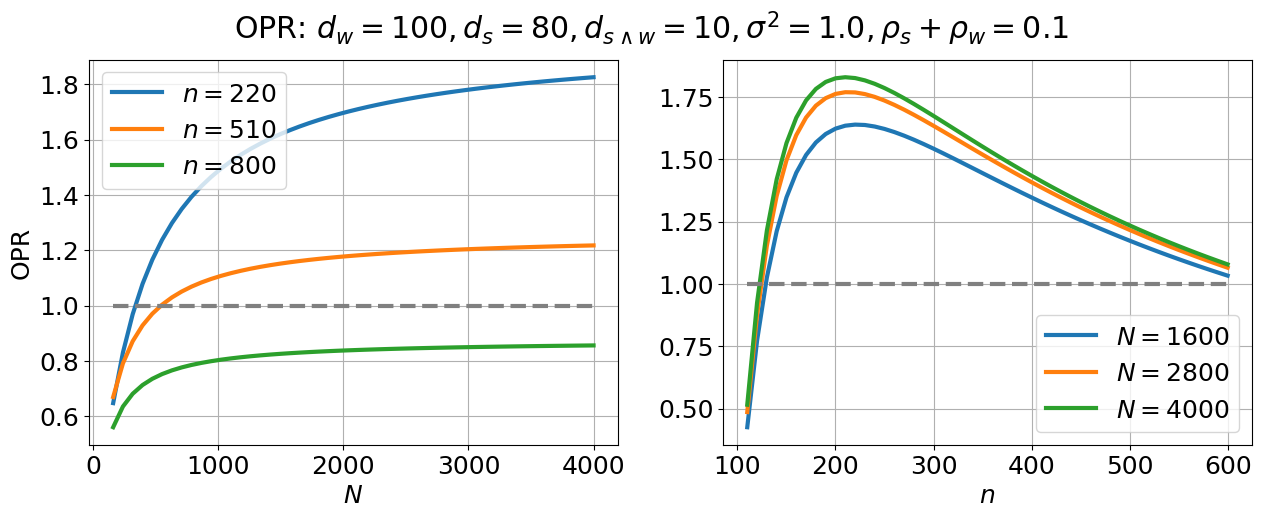

In [2]:
def pgr_lowerbd(N, n, dw, ds, dsw, var, esterr_w):
    dswN = dsw + (dw-dsw) * ds / N
    from_var = n / (n - dw - 1) * dswN / dw 
    from_esterr = n / dw * esterr_w / var
    return 1 - from_var - from_esterr

def opr_lowerbd(N, n, dw, ds, dsw, var, esterr_w):
    dswN = dsw + (dw-dsw) * ds / N
    from_var = n / (n - dw - 1) * dswN / ds
    from_esterr = n / ds * esterr_w / var
    return 1 / (from_var + from_esterr)


def func_double_scale(func, tag, N_range=[1000, 4000], n_range=[110, 400], nlines=3,):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(121)
    
    N_min, N_max = N_range
    n_min, n_max = n_range

    nn = torch.linspace(n_min*2, n_max, nlines, dtype=int)
    NN = torch.linspace(N_min, N_max, 50, dtype=int)
    for n in nn:
        pgr_ = func(NN, n)
        ax.plot(NN, pgr_, label=f"$n={n}$")
    ax.hlines(1, NN[0], NN[-1], linestyles='dashed', colors='gray',) #label="$PGR=1.0$"
    ax.legend()
    ax.set_xlabel("$N$")
    ax.set_ylabel(tag)
    # ax.set_title(rf'$\rho_w / \sigma^2$ = {(esterr_w/var):.0e}')

    ax = fig.add_subplot(122)
    NN = torch.linspace(N_min*10, N_max, nlines, dtype=int)
    nn = torch.linspace(dw+10, 6*dw, 50, dtype=int)
    for N in NN:
        pgr_ = func(N, nn)
        ax.plot(nn, pgr_, label=f"$N={N}$")
    ax.hlines(1, nn[0], nn[-1], linestyles='dashed', colors='gray',) #label="$PGR=1.0$"
    ax.legend()
    ax.set_xlabel("$n$")
    # ax.set_title(rf'$\rho_w / \sigma^2$ = {(ester_w/var):.0e}')

    fig.suptitle(rf'{tag}: $d_w = {dw}, d_s = {ds}, d_'r'{s \wedge w}'rf' = {dsw}, \sigma^2 = {var}, \rho_s + \rho_w = {esterr}$')

dw = 100
ds = 80
dsw = 10
var = 1.0
esterr = var * 0.1

N_min = ds * 2
N_max = ds * dw // 2
n_min = dw + 10
n_max = dw * 8
func_pgr = lambda N, n: pgr_lowerbd(N, n, dw, ds, dsw, var, esterr)
func_opr = lambda N, n: opr_lowerbd(N, n, dw, ds, dsw, var, esterr)
func_double_scale(func_pgr, 'PGR', N_range=[N_min, N_max], n_range=[n_min, n_max])
func_double_scale(func_opr, 'OPR', N_range=[N_min, N_max], n_range=[n_min, n_max])

# Simulation

In [3]:
def rademacher_rvs(size, **kwargs):
    return torch.randint(0, 2, size, **kwargs).float() * 2 - 1

def find_overlap(tensor1, tensor2):
    tensor2set = lambda x: set(x.cpu().numpy().tolist())
    set2tensor = lambda x: torch.tensor(list(x)).sort()[0]
    overlap = (tensor2set(tensor1) & tensor2set(tensor2))
    return set2tensor(overlap).int()

def tensor_setminus(tensor1, tensor2):
    tensor2set = lambda x: set(x.cpu().numpy().tolist())
    set2tensor = lambda x: torch.tensor(list(x)).sort()[0]
    diff = (tensor2set(tensor1) - tensor2set(tensor2))
    return set2tensor(diff).int()

class W2S_simulator:
    def __init__(self, 
                 d=1e4, dw=100, ds=50, dgt=40, doff=1, var=1.0, cov_pow=1.0,
                 lamb_gt=None, lamb_s=None, lamb_w=None, theta_gt=None,
                 seed=42, tol=TOL_FP):
        self.d = int(d)
        self.dw = int(dw)
        self.ds = int(ds)
        self.dgt = int(dgt)
        self.var = var
        self.doff = int(doff)
        self.seed = 1
        self.tol = tol
        self.cov_pow = cov_pow
        # self.set_seed()
        if lamb_gt is None:
            self.lamb_gt = torch.cat([torch.arange(1,self.dgt+1)**(-cov_pow), torch.zeros(self.d-self.dgt)])
        else:
            self.lamb_gt = torch.tensor(lamb_gt)
        if lamb_s is None:
            self.lamb_s = torch.cat([torch.arange(1,self.ds+1)**(-cov_pow), torch.zeros(self.d-self.ds)])
        else:
            self.lamb_s = torch.tensor(lamb_s)
        if lamb_w is None:
            self.lamb_w = torch.cat([torch.zeros(self.doff), torch.arange(self.doff,self.dw+self.doff)**(-cov_pow), torch.zeros(self.d-self.dw-self.doff)])
        else:
            self.lamb_w = torch.tensor(lamb_w)
        if theta_gt is None:
            self.theta_gt = rademacher_rvs([self.d]) / np.sqrt(self.d)
        else:
            self.theta_gt = torch.tensor(theta_gt)
        self.reset_seed(seed)
        self.dsw = self.get_correlation()
        self.relevant_rank = self.get_relevant_rank()
        self.esterr_w, self.esterr_s = self.get_estimation_error()
        print(f'd = {self.d}, dw = {self.dw}, ds = {self.ds}, dgt = {self.dgt}, dsw = {self.dsw}, var = {self.var}, tol = {self.tol}, esterr_w = {self.esterr_w:.2e}, esterr_s = {self.esterr_s:.2e}, esterr = {self.esterr_w + self.esterr_s:.2e}')
            
    def bd_exrisk_w2s(self, n, N):
        variance = self.var * (self.dsw + (self.dw - self.dsw) * self.ds / N) / (n - self.dw - 1)
        bias = self.esterr_w + self.esterr_s
        return variance + bias
    
    def bd_exrisk_w(self, n, N):
        exrisk = (self.var * self.dw / n) + self.esterr_w
        if exrisk.shape == torch.Size([]):
            exrisk = exrisk * torch.ones(len(N))
        return exrisk

    def bd_exrisk_s(self, n, N):
        exrisk = (self.var * self.ds / n) + self.esterr_s
        if exrisk.shape == torch.Size([]):
            exrisk = exrisk * torch.ones(len(N))
        return exrisk
    
    def bd_exrisk_c(self, n, N):
        return (self.var * self.ds / (n + N)) + self.esterr_s
    
    def bd_pgr(self, n, N):
        er_w2s = self.bd_exrisk_w2s(n, N)
        er_w = self.bd_exrisk_w(n, N)
        er_c = self.bd_exrisk_c(n, N)
        pgr = (er_w - er_w2s) / (er_w - er_c)
        # dswN = self.dsw + (self.dw-self.dsw) * self.ds / N
        # from_var = n / (n - self.dw - 1) * dswN / self.dw 
        # from_esterr = n / self.dw * (self.esterr_w + self.esterr_s) / self.var
        # pgr = 1 - from_var - from_esterr
        return pgr
    
    def bd_opr(self, n, N):
        er_s = self.bd_exrisk_s(n, N)
        er_w2s = self.bd_exrisk_w2s(n, N)
        opr = er_s / er_w2s
        # dswN = self.dsw + (self.dw-self.dsw) * self.ds / N
        # from_var = n / (n - self.dw - 1) * dswN / self.ds
        # from_esterr = n / self.ds * (self.esterr_w + self.esterr_s) / self.var
        # opr = 1 / (from_var + from_esterr)
        return opr
    
    def set_seed(self):
        torch.manual_seed(self.seed)
        self.seed += 1
        
    def reset_seed(self, seed):
        self.seed = seed
        torch.manual_seed(self.seed)
        
    def get_correlation(self,): 
        nonzero_s = torch.where(self.lamb_s > self.tol)[0]
        nonzero_w = torch.where(self.lamb_w > self.tol)[0]
        overlap = find_overlap(nonzero_s, nonzero_w)
        return len(overlap)
        
    def get_relevant_rank(self,):
        lamb2rk = lambda lamb_: self.get_mask(lamb_)[-1] + 1
        return max(lamb2rk(self.lamb_gt), lamb2rk(self.lamb_s), lamb2rk(self.lamb_w))
    
    def get_mask(self, lamb):
        return torch.where(torch.abs(lamb) > self.tol)[0]
    
    def get_estimation_error(self,):
        mask_gt = self.get_mask(self.lamb_gt)
        mask_s = self.get_mask(self.lamb_s)
        mask_w = self.get_mask(self.lamb_w)
        mask_off_w = tensor_setminus(mask_gt, mask_w)
        mask_off_s = tensor_setminus(mask_gt, mask_s)
        # print(len(mask_off_w), len(mask_off_s))
        if len(mask_off_w) == 0:
            esterr_w = 0.0
        else:
            esterr_w = torch.norm(torch.sqrt(self.lamb_gt[mask_off_w]) * self.theta_gt[mask_off_w])**2
        if len(mask_off_s) == 0:
            esterr_s = 0.0
        else:
            esterr_s = torch.norm(torch.sqrt(self.lamb_gt[mask_off_s]) * self.theta_gt[mask_off_s])**2
        return esterr_w, esterr_s
                   
    def draw_samples(self, n):
        Z = torch.randn(n, self.relevant_rank)
        phi_gt = Z * torch.sqrt(self.lamb_gt[:self.relevant_rank])
        f_gt = phi_gt @ self.theta_gt[:self.relevant_rank].reshape(-1,1)
        y = f_gt + torch.randn(n).reshape(f_gt.shape) * np.sqrt(self.var)
        # phi_s = Z * torch.sqrt(self.lamb_s)
        # phi_w = Z * torch.sqrt(self.lamb_w)
        return Z, y, f_gt
    
    def linear_probe(self, lamb, Z, y):
        coord_relevant = self.get_mask(lamb)
        phi_relevant = Z[:,coord_relevant] * torch.sqrt(lamb[coord_relevant])
        sol_relevant = torch.linalg.lstsq(phi_relevant, y, rcond=1e-6).solution
        theta = torch.zeros(self.d)
        theta[coord_relevant] = sol_relevant.reshape(-1)
        return theta
    
    def finetuned_model(self, lamb, theta):
        coord_relevant = self.get_mask(lamb)
        return lambda Z: (Z[:,coord_relevant] * torch.sqrt(lamb[coord_relevant])) @ theta[coord_relevant]
    
    def excess_risk_(self, fun, Z, f_gt):
        return torch.mean((fun(Z) - f_gt)**2)
    
    def excess_risk(self, lamb, theta):
        res = torch.sqrt(lamb[:self.relevant_rank]) * theta[:self.relevant_rank] - torch.sqrt(self.lamb_gt[:self.relevant_rank]) * self.theta_gt[:self.relevant_rank]
        return torch.norm(res, p=2)**2
        
    def run_simulation_(self, n, N, verbose=True):
        Z_sft, y_sft, _ = self.draw_samples(int(n))
        Z_uns, y_uns, _ = self.draw_samples(int(N))
        
        # Weak teacher
        theta_w = self.linear_probe(self.lamb_w, Z_sft, y_sft)
        fun_w = self.finetuned_model(self.lamb_w, theta_w)
        er_w = self.excess_risk(self.lamb_w, theta_w)
        # Strong baseline
        theta_s = self.linear_probe(self.lamb_s, Z_sft, y_sft)
        er_s = self.excess_risk(self.lamb_s, theta_s)
        # Strong ceiling
        Z_total = torch.cat([Z_sft, Z_uns])
        y_total = torch.cat([y_sft, y_uns])
        theta_c = self.linear_probe(self.lamb_s, Z_total, y_total)
        er_c = self.excess_risk(self.lamb_s, theta_c)
        # W2S
        y_w2s = fun_w(Z_uns)
        theta_w2s = self.linear_probe(self.lamb_s, Z_uns, y_w2s)
        er_w2s = self.excess_risk(self.lamb_s, theta_w2s)
        
        pgr = (er_w - er_w2s) / (er_w - er_c)
        opr = er_s / er_w2s
        if verbose:
            print(f'n = {int(n)}, N = {int(N)} | excess risk: w={er_w:.2f}, s={er_s:.2f}, c={er_c:.2f}, w2s={er_w2s:.2f} | PGR={pgr:.2f}, OPR={opr:.2f}')
        return er_w2s, er_w, er_s, er_c, pgr, opr
    
    def run_simulation(self, n, N, trials=1, verbose=True):
        pgrs = []
        oprs = []
        er_w2ss = []
        er_ws = []
        er_ss = []
        er_cs = []
        for i in range(trials):
            er_w2s, er_w, er_s, er_c, pgr, opr = self.run_simulation_(n, N, verbose=False)
            pgrs.append(pgr)
            oprs.append(opr)
            er_w2ss.append(er_w2s)
            er_ws.append(er_w)
            er_ss.append(er_s)
            er_cs.append(er_c)
        if verbose:
            print(f'n = {int(n)}, N = {int(N)} | PGR={pgr:.2f}, OPR={opr:.2f}, W2S={er_w2s:.2f}, Weak={er_w:.2f}, StrongBase={er_s:.2f}, StrongCeiling={er_c:.2f}')
        results = {
            'ew2s': (torch.mean(torch.tensor(er_w2ss)), torch.std(torch.tensor(er_w2ss))),
            'ew': (torch.mean(torch.tensor(er_ws)), torch.std(torch.tensor(er_ws))),
            'es': (torch.mean(torch.tensor(er_ss)), torch.std(torch.tensor(er_ss))),
            'ec': (torch.mean(torch.tensor(er_cs)), torch.std(torch.tensor(er_cs))),
            'pgr': (torch.mean(torch.tensor(pgrs)), torch.std(torch.tensor(pgrs))),
            'opr': (torch.mean(torch.tensor(oprs)), torch.std(torch.tensor(oprs))),
        }
        return results

## Scaling wrt n, N

In [7]:
legend_dict = {
    'ew2s': 'W2S',
    'ew': 'Weak',
    'es': 'S-Baseline',
    'ec': 'S-Ceiling',
    'pgr': 'PGR',
    'opr': 'OPR',
}

bounds_dict = {
    'ew2s': lambda n, N, simulator: simulator.bd_exrisk_w2s(n, N),
    'ew': lambda n, N, simulator: simulator.bd_exrisk_w(n, N),
    'es': lambda n, N, simulator: simulator.bd_exrisk_s(n, N),
    'ec': lambda n, N, simulator: simulator.bd_exrisk_c(n, N),
    'pgr': lambda n, N, simulator: simulator.bd_pgr(n, N),
    'opr': lambda n, N, simulator: simulator.bd_opr(n, N),
}


def simulation_sample_scale(simulator, 
    n_range=[110, 400], N_range=[1000, 4000], nstart=None, Nstart=None,
    npts=20, nlines=3, trials=10
):
    N_min, N_max = N_range
    n_min, n_max = n_range
    nstart = n_min*2 if nstart is None else nstart
    Nstart = N_min*10 if Nstart is None else Nstart
    metrics = ['ew2s', 'ew', 'es', 'ec', 'pgr', 'opr']

    nn = torch.linspace(nstart, n_max, nlines, dtype=int)
    NN = torch.linspace(N_min, N_max, npts, dtype=int)
    val_scal_N = {m: (torch.zeros(nlines, npts), torch.zeros(nlines, npts)) for m in metrics}
    val_scal_N['nn'] = nn
    val_scal_N['NN'] = NN
    for i, n in enumerate(nn):
        for j, N in enumerate(NN):
            results = simulator.run_simulation(n, N, trials=trials, verbose=False)
            for key, val in results.items():
                mean, std = val
                val_scal_N[key][0][i,j] = mean
                val_scal_N[key][1][i,j] = std
            if j==0:
                print(f'n = {n}')
    print("Scaling N done")
                
    NN = torch.linspace(Nstart, N_max, nlines, dtype=int)
    nn = torch.linspace(n_min, n_max, npts, dtype=int)
    val_scal_n = {m: (torch.zeros(nlines, npts), torch.zeros(nlines, npts)) for m in metrics}
    val_scal_n['nn'] = nn
    val_scal_n['NN'] = NN
    for i, N in enumerate(NN):
        for j, n in enumerate(nn):
            results = simulator.run_simulation(n, N, trials=trials, verbose=False)
            for key, val in results.items():
                mean, std = val
                val_scal_n[key][0][i,j] = mean
                val_scal_n[key][1][i,j] = std
            if j==0:
                print(f'N = {N}')
    print("Scaling n done")
    
    return val_scal_N, val_scal_n


bounds = ['ew2s', 'ew', 'es', 'ec']
def plot_sample_scale(val_scal_N, val_scal_n, simulator, metrics=['ew2s', 'ew', 'es', 'ec'], bounds=bounds, ylabel='Excess risk', ylog=True, ncol_legend=4):
    dw = simulator.dw
    ds = simulator.ds
    dsw = simulator.dsw
    var = simulator.var
    esterr_w = simulator.esterr_w
    esterr_s = simulator.esterr_s
    
    fig = plt.figure(figsize=(16, 5.5))
    lgds = []
    ax = fig.add_subplot(122)
    nn = val_scal_N['nn']
    NN = val_scal_N['NN']
    for i, n in enumerate(nn):
        for met in metrics:
            val = val_scal_N[met][0][i]
            val_std = val_scal_N[met][1][i]
            line = ax.errorbar(NN, val, yerr=val_std, label=legend_dict[met], fmt='-')
            if met in bounds:
                bd = bounds_dict[met](n, NN, simulator)
                # if met in ['ew','es']:
                #     bd *= 1.1
                ax.plot(NN, bd, label=f"{legend_dict[met]} Bound", color=line[0].get_color(), linestyle=':')
    if ylog:
        ax.set_yscale('log')
    ax.set_xlabel("$N$")
    ax.set_title(f'$n={n}$')

    ax = fig.add_subplot(121)
    NN = val_scal_n['NN']
    nn = val_scal_n['nn']
    for i, N in enumerate(NN):
        for met in metrics:
            val = val_scal_n[met][0][i]
            val_std = val_scal_n[met][1][i]
            line = ax.errorbar(nn, val, yerr=val_std, label=legend_dict[met], fmt='-')
            if met in bounds:
                bd = bounds_dict[met](nn, N, simulator)
                # if met in ['ew','es']:
                #     bd *= 1.1
                ax.plot(nn, bd, label=f"{legend_dict[met]} Bound", color=line[0].get_color(), linestyle=':')
    if ylog:
        ax.set_yscale('log')
    ax.set_xlabel("$n$")
    ax.set_title(f'$N={N}$')
    ax.set_ylabel(ylabel)
    # ax.set_yticks([1e-4, 1e-3])
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, -0.12), ncol=ncol_legend)
    lgds.append(lgd)
    
    fig.suptitle(rf'$d_w = {dw}, d_s = {ds}, d_'r'{s \wedge w}'rf' = {dsw}, \sigma^2 = {var:.0e}, \rho_w = {esterr_w:.1e}, \rho_s = {esterr_s:.1e}$', y=1.03)
    return fig, lgds

### Excess risk

In [8]:
dw = 200    
ds = 100
d = dw * ds
doff = 90
var = 1e-2
dgt = ds + dw
cov_pow = 1.0
torch.manual_seed(42)
simulator = W2S_simulator(d=d, dw=dw, ds=ds, dgt=dgt, doff=doff, var=var, cov_pow=cov_pow)

nstart = dw * 10
N_min = ds * 4
N_max = ds * 40

Nstart = ds * 40
n_min = dw * 2
n_max = dw * 20

val_scal_N, val_scal_n = simulation_sample_scale(simulator, n_range=[n_min, n_max], N_range=[N_min, N_max], nstart=nstart, Nstart=Nstart, trials=40, nlines=1, npts=20)

d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 10, var = 0.01, tol = 1e-12, esterr_w = 2.56e-04, esterr_s = 5.48e-05, esterr = 3.11e-04
n = 2000
Scaling N done
N = 4000
Scaling n done


(<Figure size 1600x550 with 2 Axes>,
 [<matplotlib.legend.Legend at 0x7fbfa87968e0>])

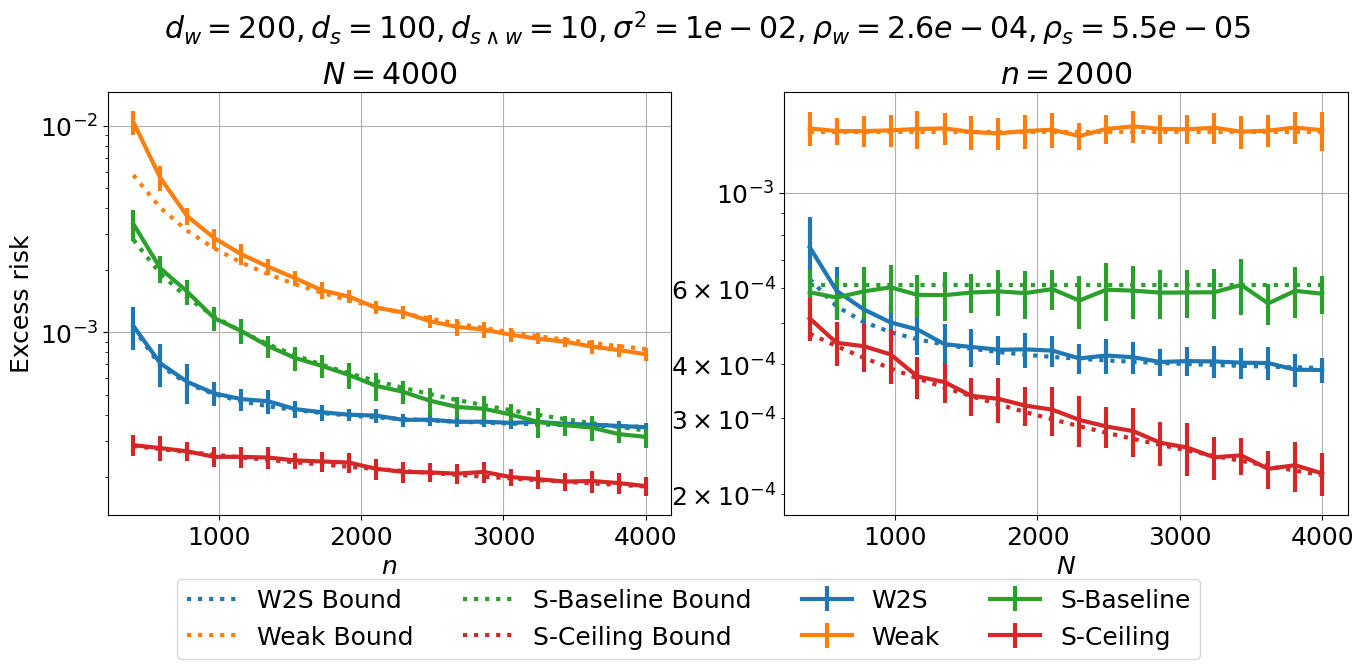

In [9]:
bounds = ['ew2s',]
bounds = ['ew2s', 'ew', 'es', 'ec']
plot_sample_scale(val_scal_N, val_scal_n, simulator, bounds=bounds, ylog=True)

In [65]:
dw = 200    
ds = 100
d = dw * ds
doff = 10
var = 1e-2
dgt = ds + dw
cov_pow = 1.0
torch.manual_seed(42)
simulator = W2S_simulator(d=d, dw=dw, ds=ds, dgt=dgt, doff=doff, var=var, cov_pow=cov_pow)

nstart = dw * 10
N_min = ds * 4
N_max = ds * 40

Nstart = ds * 40
n_min = dw * 2
n_max = dw * 20

val_scal_N_s2, val_scal_n_s2 = simulation_sample_scale(simulator, n_range=[n_min, n_max], N_range=[N_min, N_max], nstart=nstart, Nstart=Nstart, trials=40, nlines=1, npts=20)

d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 90, var = 0.01, tol = 1e-12, esterr_w = 1.64e-04, esterr_s = 5.48e-05, esterr = 2.19e-04
n = 2000
Scaling N done
N = 4000
Scaling n done


(<Figure size 1600x550 with 2 Axes>,
 [<matplotlib.legend.Legend at 0x7fe988db1760>])

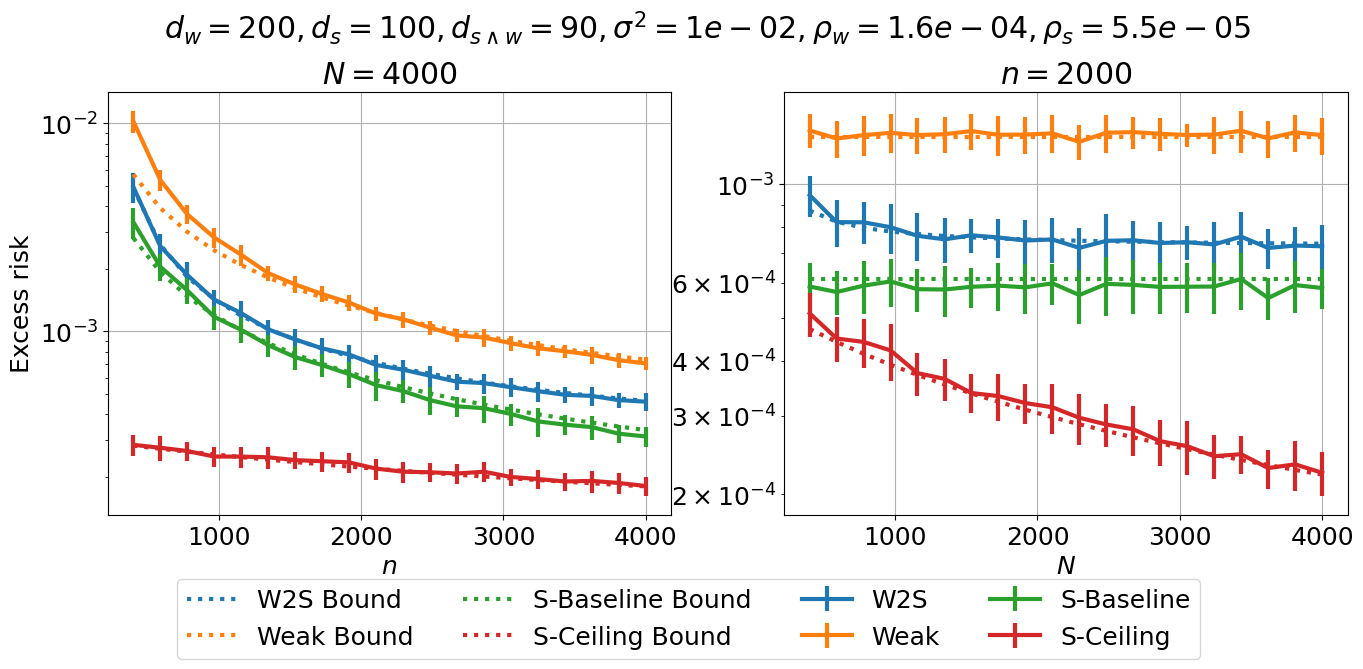

In [66]:
bounds = ['ew2s',]
bounds = ['ew2s', 'ew', 'es', 'ec']
plot_sample_scale(val_scal_N_s2, val_scal_n_s2, simulator, bounds=bounds, ylog=True)

In [67]:
dw = 200    
ds = 100
d = dw * ds
doff = 10
var = 4e-4
dgt = ds + dw
cov_pow = 1.0
torch.manual_seed(42)
simulator = W2S_simulator(d=d, dw=dw, ds=ds, dgt=dgt, doff=doff, var=var, cov_pow=cov_pow)

nstart = dw * 10
N_min = ds * 4
N_max = ds * 40

Nstart = ds * 40
n_min = dw * 2
n_max = dw * 20

val_scal_N_f1, val_scal_n_f1 = simulation_sample_scale(simulator, n_range=[n_min, n_max], N_range=[N_min, N_max], nstart=nstart, Nstart=Nstart, trials=40, nlines=1, npts=20)

d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 90, var = 0.0004, tol = 1e-12, esterr_w = 1.64e-04, esterr_s = 5.48e-05, esterr = 2.19e-04
n = 2000
Scaling N done
N = 4000
Scaling n done


(<Figure size 1600x550 with 2 Axes>,
 [<matplotlib.legend.Legend at 0x7fe999a42e50>])

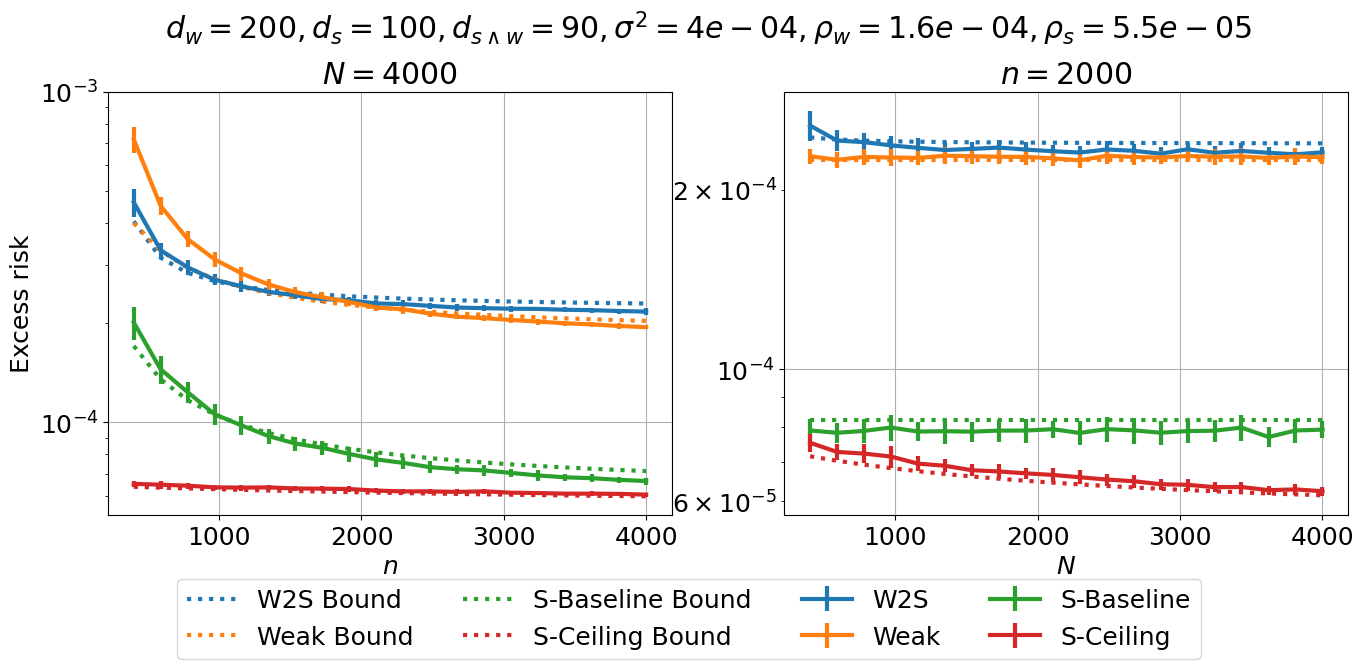

In [70]:
bounds = ['ew2s',]
bounds = ['ew2s', 'ew', 'es', 'ec']
plot_sample_scale(val_scal_N_f1, val_scal_n_f1, simulator, bounds=bounds, ylog=True)

### PGR and OPR

In [32]:
def simulation_sample_scale_dsw(simulators, 
    n_range=[110, 400], N_range=[1000, 4000], nstart=None, Nstart=None,
    npts=20, trials=10,
):
    N_min, N_max = N_range
    n_min, n_max = n_range
    nstart = n_min*2 if nstart is None else nstart
    Nstart = N_min*10 if Nstart is None else Nstart
    metrics = ['ew2s', 'ew', 'es', 'ec', 'pgr', 'opr']

    NN = torch.linspace(N_min, N_max, npts, dtype=int)
    val_scal_N = {m: (torch.zeros(len(simulators), npts), torch.zeros(len(simulators), npts)) for m in metrics}
    val_scal_N['dsw'] = torch.Tensor([simulator.dsw for simulator in simulators])
    val_scal_N['n'] = nstart
    val_scal_N['NN'] = NN
    for i, simulator in enumerate(simulators):
        for j, N in enumerate(NN):
            results = simulator.run_simulation(nstart, N, trials=trials, verbose=False)
            for key, val in results.items():
                mean, std = val
                val_scal_N[key][0][i,j] = mean
                val_scal_N[key][1][i,j] = std
            if j==0:
                print(f'n = {nstart}')
    print("Scaling N done")
                
    nn = torch.linspace(n_min, n_max, npts, dtype=int)
    val_scal_n = {m: (torch.zeros(len(simulators), npts), torch.zeros(len(simulators), npts)) for m in metrics}
    val_scal_n['dsw'] = torch.Tensor([simulator.dsw for simulator in simulators])
    val_scal_n['N'] = Nstart
    val_scal_n['nn'] = nn
    for i, simulator in enumerate(simulators):
        for j, n in enumerate(nn):
            results = simulator.run_simulation(n, Nstart, trials=trials, verbose=False)
            for key, val in results.items():
                mean, std = val
                val_scal_n[key][0][i,j] = mean
                val_scal_n[key][1][i,j] = std
            if j==0:
                print(f'N = {Nstart}')
    print("Scaling n done")
    return val_scal_N, val_scal_n

ylabel_dict = {'pgr': 'PGR', 'opr': 'OPR'}
def plot_sample_scale(val_scal_N, val_scal_n, simulators, metrics=['pgr','opr'], ylog=False, ncol_legend=3, figsize=(15, 9)):
    fig = plt.figure(figsize=figsize)
    lgds = []
    for i_met, metric in enumerate(metrics):
        ax = fig.add_subplot(len(metrics), 2, 2*i_met+2)
        dsws = val_scal_N['dsw']
        n = val_scal_N['n']
        NN = val_scal_N['NN']
        for i, dsw in enumerate(dsws):
            val = val_scal_N[metric][0][i]
            val_std = val_scal_N[metric][1][i]
            line = ax.errorbar(NN, val, yerr=val_std, label=r'$d_{s \wedge w}'f'={dsw}$', fmt='-')
            bd = bounds_dict[metric](n, NN, simulators[i])
            ax.plot(NN, bd, label=r'$d_{s \wedge w}'f'={dsw}$ Bound', color=line[0].get_color(), linestyle=':')
        if ylog:
            ax.set_yscale('log')
        if i_met==len(metrics)-1:
            ax.set_xlabel("$N$")
        if i_met==0:
            ax.set_title(f'$n={n}$')

        ax = fig.add_subplot(len(metrics), 2, 2*i_met+1)
        dsws = val_scal_n['dsw']
        N = val_scal_n['N']
        nn = val_scal_n['nn']
        for i, dsw in enumerate(dsws):
            val = val_scal_n[metric][0][i]
            val_std = val_scal_n[metric][1][i]
            line = ax.errorbar(nn, val, yerr=val_std, label=r'$d_{s \wedge w}'f'={dsw}$', fmt='-')
            bd = bounds_dict[metric](nn, N, simulators[i])
            ax.plot(nn, bd, label=r'$d_{s \wedge w}'f'={dsw}$ Bound', color=line[0].get_color(), linestyle=':')
        if ylog:
            ax.set_yscale('log')
        if i_met==len(metrics)-1:
            ax.set_xlabel("$n$")
        if i_met==0:
            ax.set_title(f'$N={N}$')
        ax.set_ylabel(ylabel_dict[metric])
        if i_met==len(metrics)-1:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, -0.16), ncol=ncol_legend)
            lgds.append(lgd)
    
    dw = simulators[0].dw
    ds = simulators[0].ds
    var = simulators[0].var
    dsws2str = ', '.join([str(simulator.dsw) for simulator in simulators])
    esterr_w = torch.max(torch.tensor([simulator.esterr_w for simulator in simulators]))
    esterr_s = torch.max(torch.tensor([simulator.esterr_s for simulator in simulators]))
    strw2s = r'{s \wedge w}'
    fig.suptitle(rf'$d_w = {dw}, d_s = {ds}, \sigma^2 = {var:.0e}, d_{strw2s} = {dsws2str}, \rho_w < {esterr_w:.1e}, \rho_s < {esterr_s:.1e}$', y=0.97)
    return fig, lgds

In [11]:
dw = 200    
ds = 100
d = dw * ds
var = 1e-2
dgt = ds + dw
cov_pow = 1.0

nstart = dw * 10
N_min = ds * 4
N_max = ds * 40

Nstart = ds * 40
n_min = dw * 2
n_max = dw * 20

doffs = [10, 50, 90]
simulators = [W2S_simulator(d=d, dw=dw, ds=ds, dgt=dgt, doff=doff, var=var, cov_pow=cov_pow) for doff in doffs]
torch.manual_seed(42)

val_scal_N, val_scal_n = simulation_sample_scale_dsw(simulators, n_range=[n_min, n_max], N_range=[N_min, N_max], nstart=nstart, Nstart=Nstart, trials=40, npts=20)

d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 90, var = 0.01, tol = 1e-12, esterr_w = 1.64e-04, esterr_s = 5.48e-05, esterr = 2.19e-04
d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 50, var = 0.01, tol = 1e-12, esterr_w = 2.34e-04, esterr_s = 5.48e-05, esterr = 2.89e-04
d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 10, var = 0.01, tol = 1e-12, esterr_w = 2.56e-04, esterr_s = 5.48e-05, esterr = 3.11e-04
n = 2000
n = 2000
n = 2000
Scaling N done
N = 4000
N = 4000
N = 4000
Scaling n done


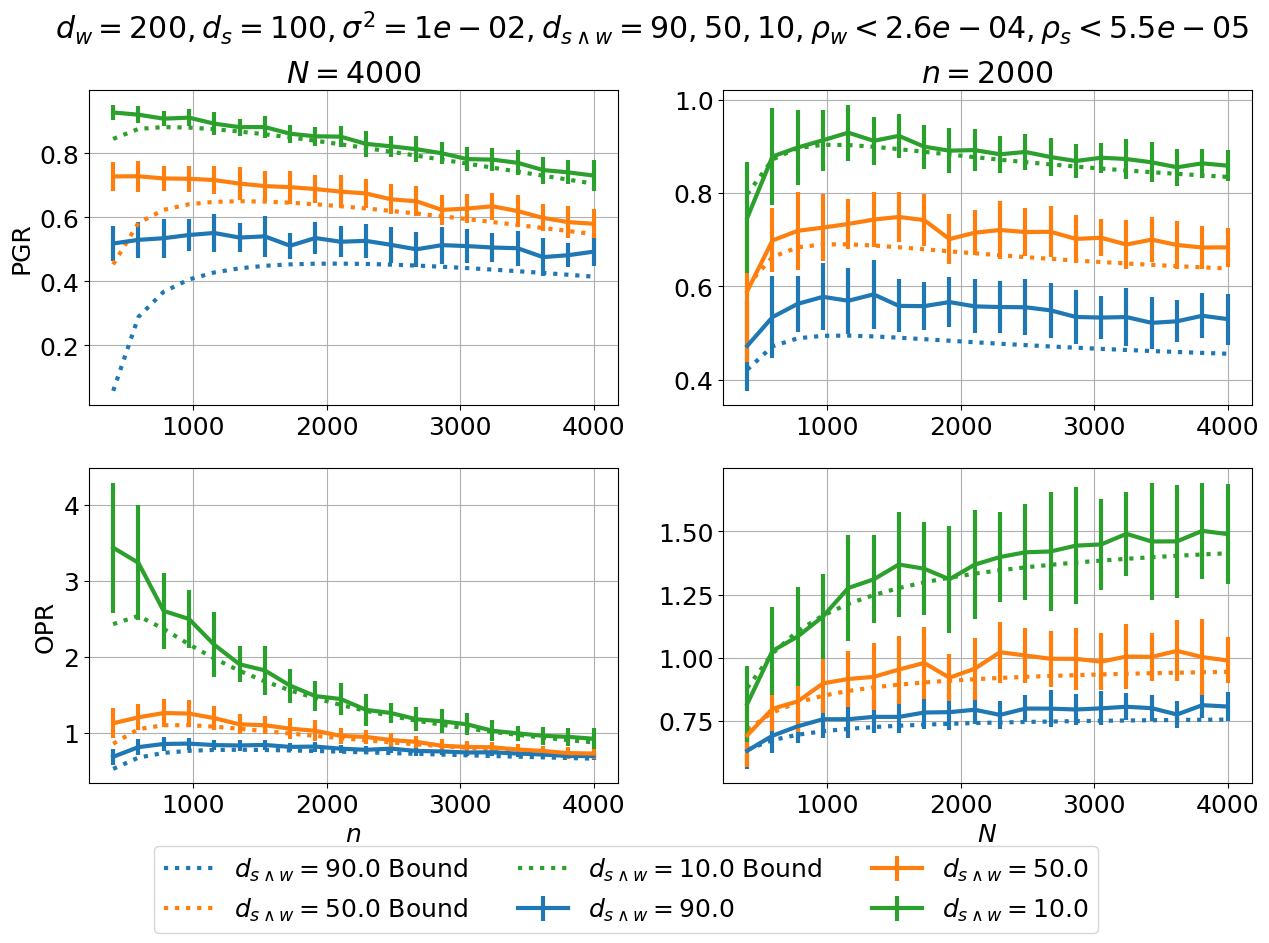

In [33]:
fig, lgds = plot_sample_scale(val_scal_N, val_scal_n, simulators)

In [78]:
dw = 200    
ds = 100
d = dw * ds
var = 1e-2
dgt = ds + dw
cov_pow = 1.0

nstart = dw * 10
N_min = ds * 4
N_max = ds * 40

Nstart = ds * 40
n_min = dw * 2
n_max = dw * 20

doffs = [20, 60, 100]
simulators = [W2S_simulator(d=d, dw=dw, ds=ds, dgt=dgt, doff=doff, var=var, cov_pow=cov_pow) for doff in doffs]
torch.manual_seed(42)

val_scal_N, val_scal_n = simulation_sample_scale_dsw(simulators, n_range=[n_min, n_max], N_range=[N_min, N_max], nstart=nstart, Nstart=Nstart, trials=40, npts=20)

d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 80, var = 0.01, tol = 1e-12, esterr_w = 1.95e-04, esterr_s = 5.48e-05, esterr = 2.50e-04
d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 40, var = 0.01, tol = 1e-12, esterr_w = 2.41e-04, esterr_s = 5.48e-05, esterr = 2.96e-04
d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 0, var = 0.01, tol = 1e-12, esterr_w = 2.59e-04, esterr_s = 5.48e-05, esterr = 3.14e-04
n = 2000
n = 2000
n = 2000
Scaling N done
N = 4000
N = 4000
N = 4000
Scaling n done


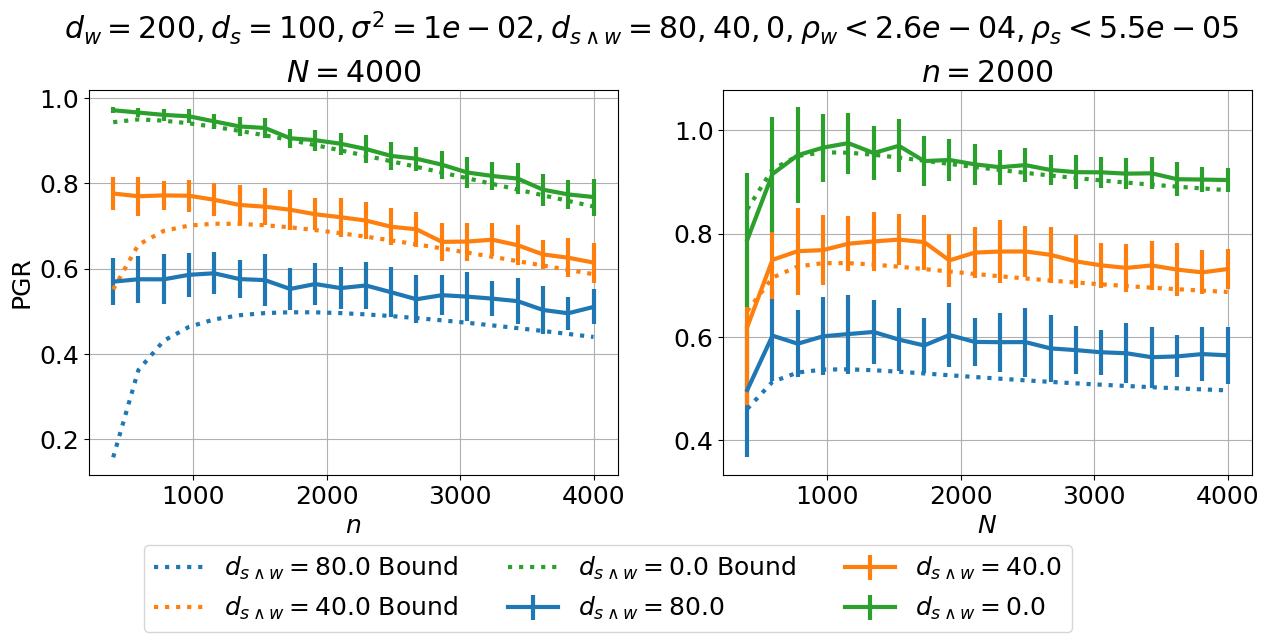

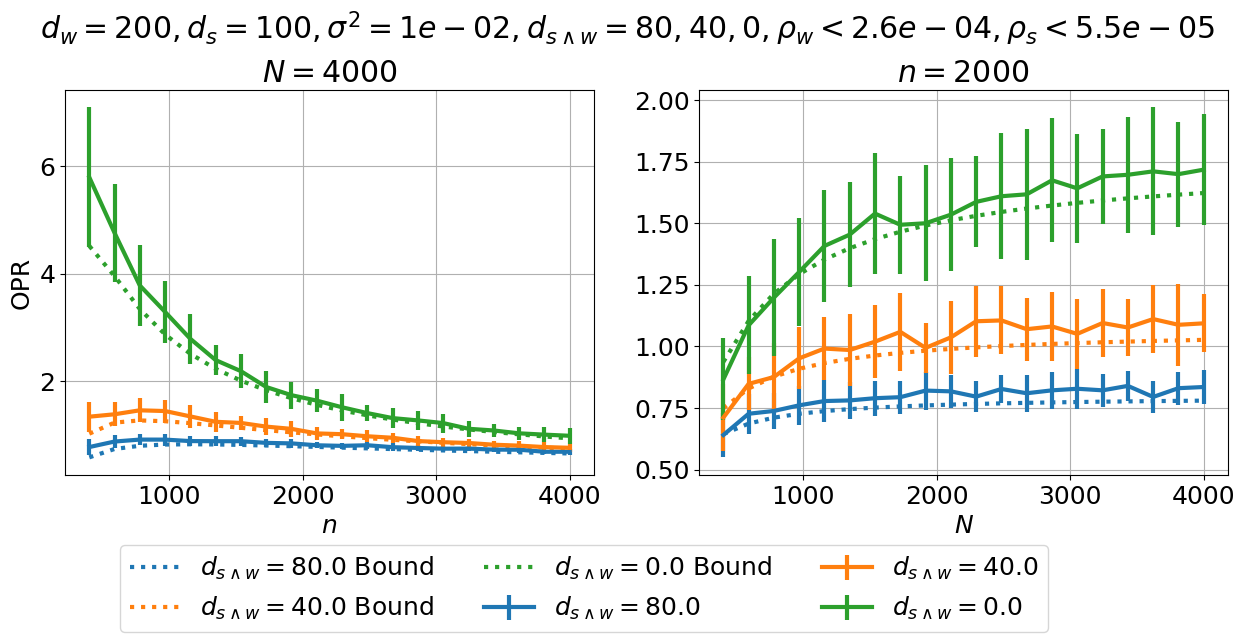

In [79]:
fig, lgds = plot_sample_scale(val_scal_N, val_scal_n, simulators)

In [8]:
dw = 200    
ds = 100
d = dw * ds
var = 0.1
dgt = ds + dw
cov_pow = 1.0

nstart = dw * 10
N_min = ds * 4
N_max = ds * 40

Nstart = ds * 40
n_min = dw * 2
n_max = dw * 20

doffs = [10, 50, 90]
simulators = [W2S_simulator(d=d, dw=dw, ds=ds, dgt=dgt, doff=doff, var=var, cov_pow=cov_pow) for doff in doffs]
torch.manual_seed(42)

val_scal_N, val_scal_n = simulation_sample_scale_dsw(simulators, n_range=[n_min, n_max], N_range=[N_min, N_max], nstart=nstart, Nstart=Nstart, trials=40, npts=20)

d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 90, var = 0.1, tol = 1e-12, esterr_w = 1.64e-04, esterr_s = 5.48e-05, esterr = 2.19e-04
d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 50, var = 0.1, tol = 1e-12, esterr_w = 2.34e-04, esterr_s = 5.48e-05, esterr = 2.89e-04
d = 20000, dw = 200, ds = 100, dgt = 300, dsw = 10, var = 0.1, tol = 1e-12, esterr_w = 2.56e-04, esterr_s = 5.48e-05, esterr = 3.11e-04
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
n = 2000
n = 2000
n = 2000
Scaling N done
N = 4000
N = 4000
N = 4000
Scaling n done


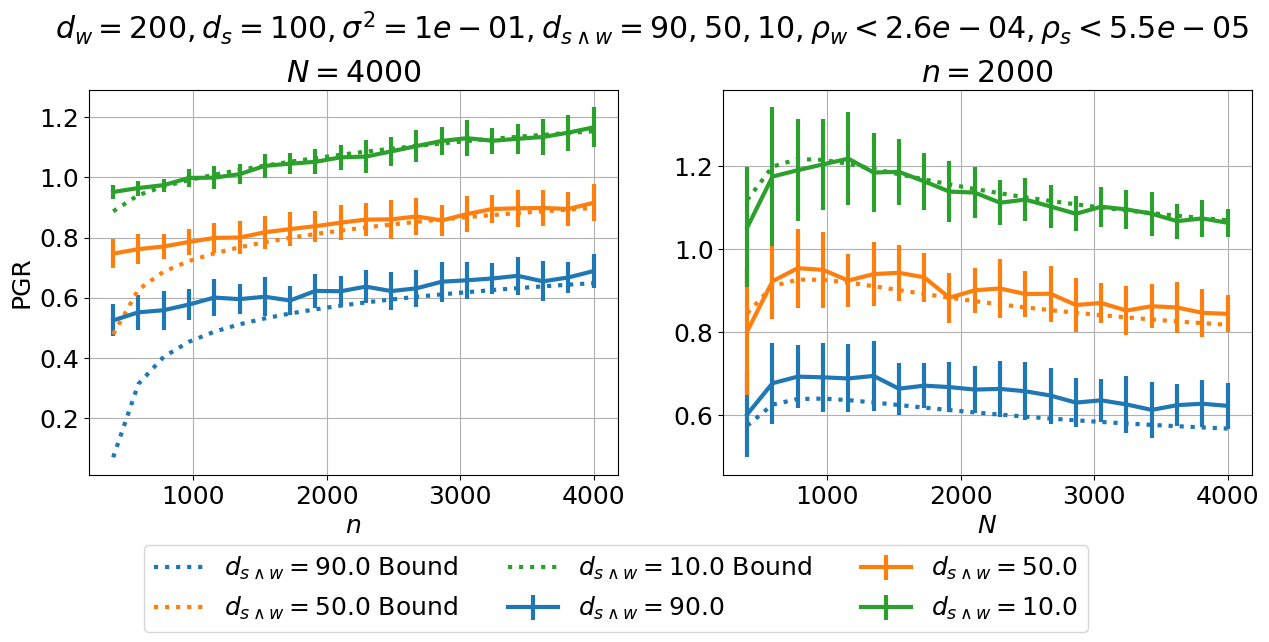

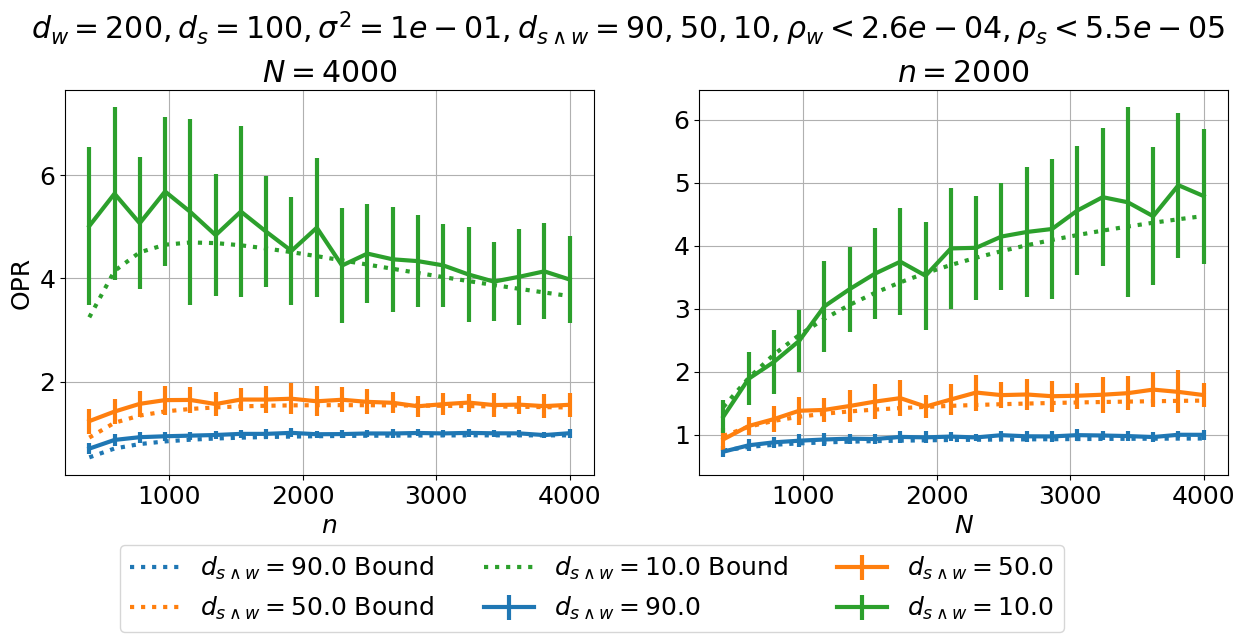

In [9]:
fig, lgds = plot_sample_scale(val_scal_N, val_scal_n, simulators)

# Old color map plotters

In [ ]:
def low_bound_cmap(dw, ds, dsw, var, esterr_w, N_range=[1000, 4000], n_range=[110, 400]):
    # Define the range for n and N
    n_range = torch.linspace(int(n_range[0]), int(n_range[1]), 100)
    N_range = torch.linspace(int(N_range[0]), int(N_range[1]), 100)

    # Create a meshgrid for n and N
    n_mesh, N_mesh = torch.meshgrid(n_range, N_range)

    # Calculate PGR for each combination of n and N
    PGR_values = pgr_lowerbd(n_mesh, N_mesh, dw, ds, dsw, var, esterr_w)
    OPR_values = opr_lowerbd(n_mesh, N_mesh, dw, ds, dsw, var, esterr_w)

    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(121)
    cmap = ax.pcolormesh(N_mesh, n_mesh, PGR_values, shading='auto', cmap='magma',)
    fig.colorbar(cmap, ax=ax, orientation='vertical', pad=0.02, format='%.2f')
    ax.set_xlabel('$N$')
    ax.set_ylabel('$n$')
    ax.set_title('PGR')
    # ax.set_xticks([N_min, 7000, 14000, 20000])
    # ax.set_yticks([n_min, 400, 700, n_max])

    ax = fig.add_subplot(122)
    # norm = mpl.colors.Normalize(vmin=min(0.0, torch.min(OPR_values)), vmax=torch.max(OPR_values))
    norm = mpl.colors.Normalize(vmin=torch.min(OPR_values), vmax=torch.max(OPR_values))
    cmap = ax.pcolormesh(N_mesh, n_mesh, OPR_values, shading='auto', cmap='magma', norm=norm)
    fig.colorbar(cmap, ax=ax, orientation='vertical', pad=0.02, format='%.1f')
    ax.set_xlabel('$N$')
    # ax.set_ylabel('$n$')
    ax.set_title('OPR')
    # ax.set_xticks([N_min, 7000, 14000, 20000])
    # ax.set_yticks([n_min, 400, 700, n_max])
    # ax.set_yticklabels([])

    fig.suptitle(rf'$d_w = {dw}, d_s = {ds}, \sigma^2 = {var}, \rho_w = {esterr_w}$', y=-0.01)
    # plt.tight_layout()
    
    return fig

# fig = low_bound_cmap(dw, ds, dsw, var, esterr, N_range=[dw*ds*0.5, dw*ds*4], n_range=[dw+10, dw*8])

def simultaion(simulator, n_range=[110, 400], N_range=[1000, 4000], resolution=[20,20]):
    # Define the range for n and N
    n_range = torch.linspace(int(n_range[0]), int(n_range[1]), resolution[0])
    N_range = torch.linspace(int(N_range[0]), int(N_range[1]), resolution[1])

    # Calculate PGR for each combination of n and N
    PGR_values = torch.zeros((N_range.shape[0], n_range.shape[0]))
    OPR_values = torch.zeros((N_range.shape[0], n_range.shape[0]))
    for i in range(N_range.shape[0]):
        for j in range(n_range.shape[0]):
            verbose = True if j==0 else False
            pgr, opr = simulator.run_simulation(n_range[j], N_range[i], verbose=verbose)
            PGR_values[i, j] = pgr
            OPR_values[i, j] = opr
            
    n_mesh, N_mesh = torch.meshgrid(n_range, N_range)
    return N_mesh, n_mesh, PGR_values, OPR_values, simulator.esterr_w, simulator.esterr_s


def simultaion_cmap(N_mesh, n_mesh, PGR_values, OPR_values, esterr_w, esterr_s,
                    opr_threshold=0.0):
    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(121)
    # norm = mpl.colors.Normalize(vmin=max(0.0, torch.min(PGR_values)), vmax=min(1.0, torch.max(PGR_values)))
    norm = mpl.colors.Normalize(vmin=torch.min(PGR_values), vmax=torch.max(PGR_values))
    cmap = ax.pcolormesh(N_mesh, n_mesh, PGR_values[1:,1:], shading='auto', cmap='magma', norm=norm)
    fig.colorbar(cmap, ax=ax, orientation='vertical', pad=0.02, format='%.2f')
    ax.set_xlabel('$N$')
    ax.set_ylabel('$n$')
    ax.set_title('PGR')
    # ax.set_xticks([N_min, 7000, 14000, 20000])
    # ax.set_yticks([n_min, 400, 700, n_max])

    ax = fig.add_subplot(122)
    if opr_threshold > 0.0:
        OPR_values_ = OPR_values * (OPR_values >= opr_threshold)
    else:
        OPR_values_ = OPR_values
    norm = mpl.colors.Normalize(vmin=torch.min(OPR_values_), vmax=torch.max(OPR_values_))
    cmap = ax.pcolormesh(N_mesh, n_mesh, OPR_values_[1:,1:], shading='auto', cmap='magma', norm=norm)
    fig.colorbar(cmap, ax=ax, orientation='vertical', pad=0.02, format='%.1f')
    ax.set_xlabel('$N$')
    # ax.set_ylabel('$n$')
    ax.set_title('OPR')
    # ax.set_xticks([N_min, 7000, 14000, 20000])
    # ax.set_yticks([n_min, 400, 700, n_max])
    # ax.set_yticklabels([])

    fig.suptitle(rf'$d_w = {dw}, d_s = {ds}, \sigma^2 = {var}, \rho_w = {esterr_w:.4f}, \rho_s = {esterr_s:.4f}$', y=-0.01)
    # plt.tight_layout()
    
    return fig